<h1 align="center">Определение перспективного региона нефтедобычи</h1>

## Краткое описание проекта

В добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. **Целью** данного проекта является определение перспективного региона для разработки, где добыча принесёт наибольшую прибыль. В рамках проекта потребуется решить следующие *задачи*:

1. Получить данные;
2. Подготовить данные для обучения на них;
3. Построить модель машинного обучения, которая поможет определить перспективный регион;
4. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые);
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- Бюджет на разработку скважин в регионе — 10 млрд рублей;
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.


## Оглавление<a id="contents"></a>

1. [Получение и подготовка данных](#start)
2. [Обучение и проверка моделей](#learn)
3. [Подготовка к расчету прибыли](#prep)
4. [Расчет прибыли и рисков](#profit)
5. [Общий вывод](#conclusion)

## 1. Получение и подготовка данных<a id="start"></a>

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os
from pathlib import Path
import urllib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Подготовим функцию для проверки наличия файлов и их загрузки при необходимости.

In [2]:
Path('/datasets').mkdir(parents=True,exist_ok=True)
def get_file(file_name, url):
    
    if not os.path.exists(file_name):
        print(file_name,'не найден. Файл будет загружен из сети')
        _ = urllib.request.urlretrieve(url, file_name)

urls = {
    'geo_data_0': ('/datasets/geo_data_0.csv', 'https://.../geo_data_0.csv'),
    'geo_data_1': ('/datasets/geo_data_1.csv', 'https://.../geo_data_1.csv'),
    'geo_data_2': ('/datasets/geo_data_2.csv', 'https://.../geo_data_2.csv')
}

[get_file(*urls[k]) for k in urls]

[None, None, None]

Сохраним предоставленные датасеты в соответствующих переменных и рассмотрим основную информацию о них. Также оценим распределение запасов нефти в каждом регионе с помощью гистограмм.

В каждой таблице 3 столбца:
1. id — уникальный идентификатор скважины;
2. f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
3. product — объём запасов в скважине (тыс. баррелей).

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
print(geo_data_0.head(), '\n')
geo_data_0.info()

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Text(0.5, 1.0, 'Гистограмма запасов региона "0"')

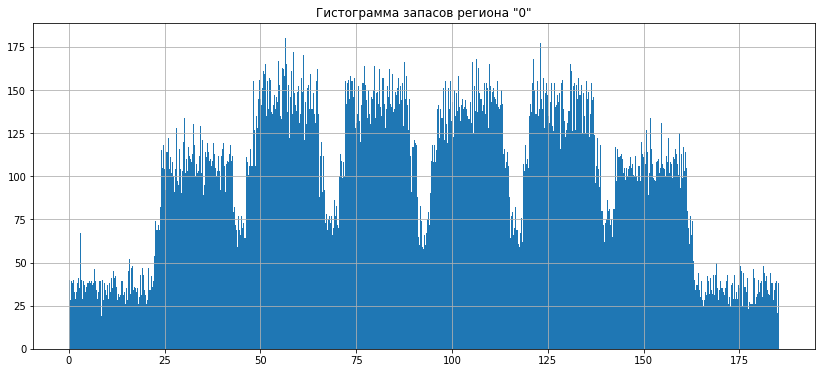

In [5]:
geo_data_0.hist('product', bins=1000, figsize=(14, 6))
plt.title('Гистограмма запасов региона "0"')

In [6]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
print(geo_data_1.head(), '\n')
geo_data_1.info()

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Text(0.5, 1.0, 'Гистограмма запасов региона "1"')

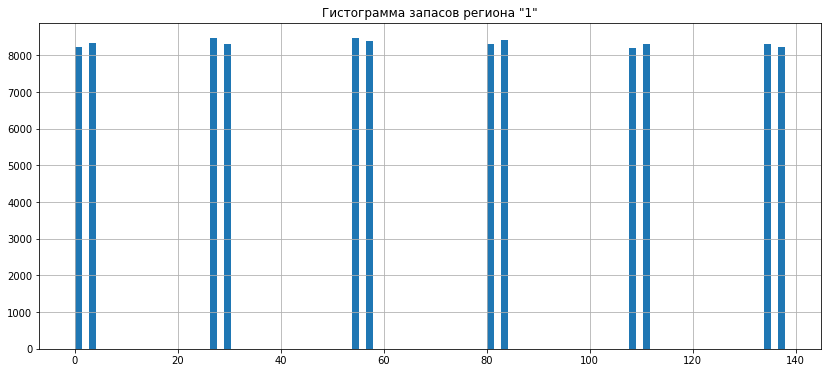

In [8]:
geo_data_1.hist('product', bins=100, figsize=(14, 6))
plt.title('Гистограмма запасов региона "1"')

In [9]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
print(geo_data_2.head(), '\n')
geo_data_2.info()

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Text(0.5, 1.0, 'Гистограмма запасов региона "2"')

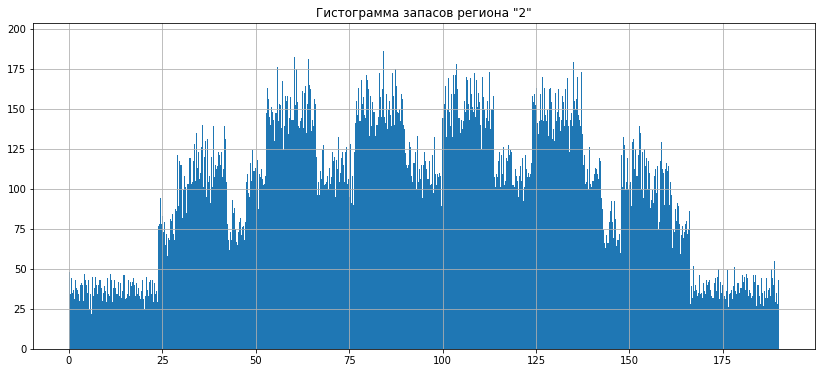

In [11]:
geo_data_2.hist('product', bins=1000, figsize=(14, 6))
plt.title('Гистограмма запасов региона "2"')

### Вывод

Предобработка данных не требуется - пропусков нет, отрицательных значений запасов тоже. При этом данные каждого региона распределены ненормально. При этом распределения регионов "0" и "2" похожи, можно сказать что запас сырья в них - непрерывная величина. А вот в регионе "1" - дискретная. 

[В начало раздела](#start)

[К оглавлению](#contents)

## 2. Обучение и проверка моделей<a id="learn"></a>

Обучим модель линейной регрессии для предсказания запасов нефти в отдельно взятом регионе. Для этого создадим функцию `model`, которая на вход получает датафрейм с данными по региону, а возвращает таблицу с правильными ответами и соответствующими им предсказаниями запасов сырья в регионе для валидационной выборки.

In [12]:
def model(data):
    target = data['product']
    features = data.drop(['product', 'id'] , axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)

    print('Средний запас предсказанного сырья для одной скважины:', predicted_valid.mean())
    print('Средний запас предсказанного сырья в регионе (200 скважин):', 200*predicted_valid.mean())
    
    print("RMSE =", mse ** 0.5, '\n')
    
    a = target_valid.reset_index(drop=True)
    b = pd.Series(predicted_valid)
    df = pd.concat([a, b], axis=1)
    df.columns = ['product', 'predicted_product']
    print(df.head())
    df.info()
    return df

Воспользовавшись функцией, получим данные для регионов.

In [13]:
df_0 = model(geo_data_0)

Средний запас предсказанного сырья для одной скважины: 92.59256778438038
Средний запас предсказанного сырья в регионе (200 скважин): 18518.513556876074
RMSE = 37.5794217150813 

      product  predicted_product
0   10.038645          95.894952
1  114.551489          77.572583
2  132.603635          77.892640
3  169.072125          90.175134
4  122.325180          70.510088
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
product              25000 non-null float64
predicted_product    25000 non-null float64
dtypes: float64(2)
memory usage: 390.8 KB


In [14]:
df_1 = model(geo_data_1)

Средний запас предсказанного сырья для одной скважины: 68.728546895446
Средний запас предсказанного сырья в регионе (200 скважин): 13745.7093790892
RMSE = 0.893099286775616 

     product  predicted_product
0  80.859783          82.663314
1  53.906522          54.431786
2  30.132364          29.748760
3  53.906522          53.552133
4   0.000000           1.243856
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
product              25000 non-null float64
predicted_product    25000 non-null float64
dtypes: float64(2)
memory usage: 390.8 KB


In [15]:
df_2 = model(geo_data_2)

Средний запас предсказанного сырья для одной скважины: 94.96504596800489
Средний запас предсказанного сырья в регионе (200 скважин): 18993.009193600978
RMSE = 40.02970873393434 

      product  predicted_product
0   61.212375          93.599633
1   41.850118          75.105159
2   57.776581          90.066809
3  100.053761         105.162375
4  109.897122         115.303310
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
product              25000 non-null float64
predicted_product    25000 non-null float64
dtypes: float64(2)
memory usage: 390.8 KB


### Вывод

В регионах "0" и "2" модели предсказывают большие запасы, однако и корень среднеквадратичной ошибки RMSE для них достаточно велик. Регион "1" отстает по предсказанным запасам, но и RMSE гораздо ниже относительно других регионов. Это можно объяснить распределением данных, отраженным в разделе 1.

[В начало раздела](#learn)

[К оглавлению](#contents)

## 3. Подготовка к расчёту прибыли<a id="prep"></a>

Сохраним ключевые значения в отдельных переменных.

In [16]:
points = 500# число исследуемых точек
best_points = 200# число лучших точек, выбранных для разработки
budget = 10000000000# бюджет, выделенный на разработку в регионе
income_per_unit = 450000# доход с единицы продукта

Расчитаем бюджет одной разрабатываемой скважины.

In [17]:
well_budget = budget / best_points
print(well_budget)

50000000.0


Расчитаем необходимый запас сырья в скважине для ее безубыточной разработки.

In [18]:
well_oil_reserve = well_budget / income_per_unit
print(well_oil_reserve)

111.11111111111111


Расчитаем необходимый запас сырья для ведения разработок в регионе.

In [19]:
region_oil_reserve = budget / income_per_unit
print(region_oil_reserve)

22222.222222222223


Подготовим функцию `get_profit` для расчета прибыли. На вход она будет получать датафрейм с истинными и предсказанными значениями количества нефти в скважинах, а возвращать прибыль от ведения разработок в данном регионе.

In [26]:
def get_profit(data):
    best_data = data.sort_values(by=['predicted_product'], ascending=False).iloc[0:best_points]# выберем 200 
                                                                                            #лучших скважин по предсказаниям
    oil = best_data['product'].sum()# посчитаем количество реального сырья
    profit = oil * income_per_unit - budget# посчитаем возможную чистую прибыль
    return profit

### Вывод

В этом разделе мы сохранили в отдельных переменных необходимые для расчета прибыли величины, посчитали необходимый запас сырья в скважине и в регионе для ведения разработок. Видно, что ведение добычи из средней шахты в любом регионе будет убыточным. Мы должны выбрать лучшие и проанализировать, какую прибыль их разработка может принести. 

[В начало раздела](#prep)

[К оглавлению](#contents)

## 4. Расчёт прибыли и рисков<a id="profit"></a>

Найдем распределение прибыли, применив технику **Bootstrap**. Для этого создадим функцию `bootstrap`, которая на вход получает датафрейм с предсказаниями и реальными значениями запасов сырья, и выводит на экран среднюю прибыль, 95%-й доверительный интевал и риск получения убытков.

In [27]:
def bootstrap(df, samples):
    state = np.random.RandomState(12345)
    values = []
    for i in range(samples):
        df_subsample = df.sample(n=points, replace=True, random_state=state)
        values.append(get_profit(df_subsample))
        
    values = pd.Series(values)
    print('Среднее значение прибыли от добычи в регионе: {:.0f}'.format(values.mean()))
    print('95%-й доверительный интевал: {:.0f},'.format(values.quantile(0.025)), '{:.0f}'.format(values.quantile(0.925)))
    print('Риск получения убытков: {:.1%}'.format((len(values[values < 0]) / len(values))))
    values.plot(kind='hist', bins=200, 
                title='Гистограмма прибыли при ведении разработок в регионе', figsize=(14, 6), grid=True)
    
    plt.xlabel('Прибыль, млрд. руб.')

Рассмотрим исследуемые регионы.

**Регион "0"**.

Среднее значение прибыли от добычи в регионе: 396164985
95%-й доверительный интевал: -111215546, 789980118
Риск получения убытков: 6.9%


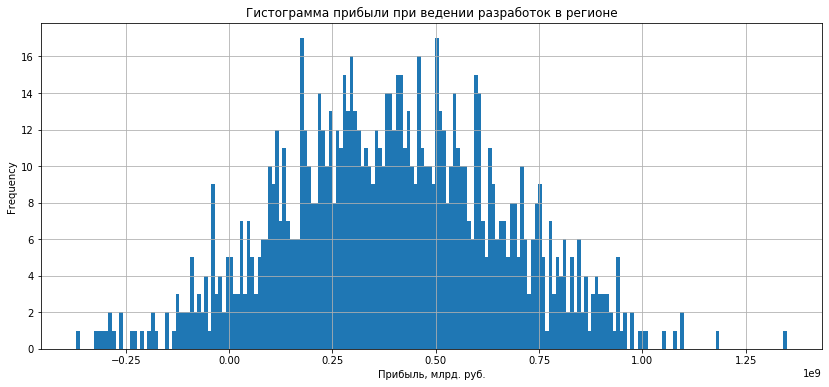

In [28]:
bootstrap(df_0, 1000)

**Регион "1"**.

Среднее значение прибыли от добычи в регионе: 456045106
95%-й доверительный интевал: 33820509, 758936834
Риск получения убытков: 1.5%


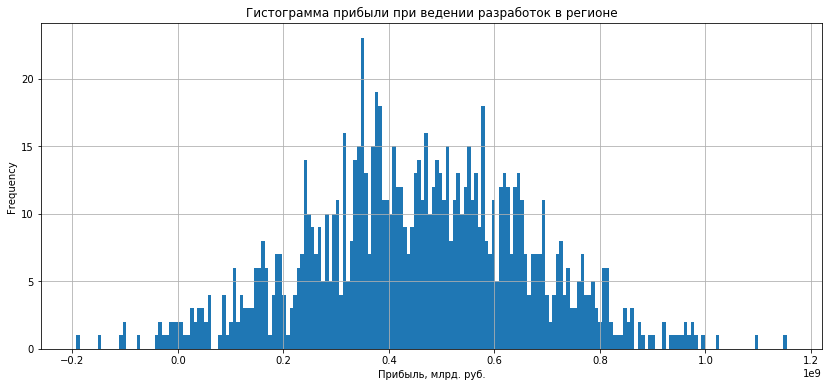

In [24]:
bootstrap(df_1, 1000)

**Регион "2"**.

Среднее значение прибыли от добычи в регионе: 404403867
95%-й доверительный интевал: -163350413, 787873198
Риск получения убытков: 7.6%


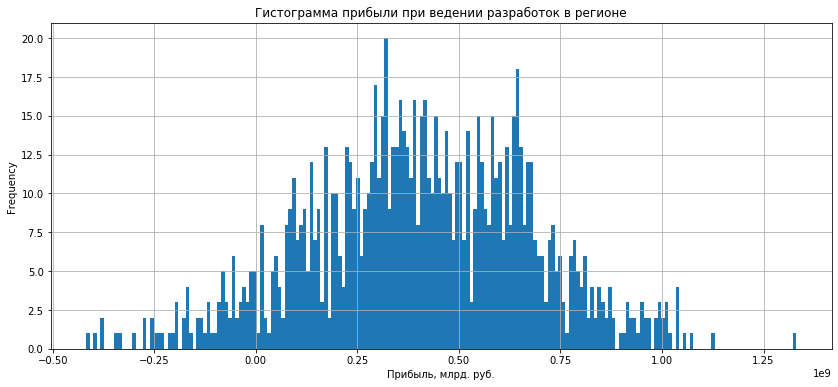

In [25]:
bootstrap(df_2, 1000)

### Вывод

Только в регионе "1" в доверительный интервал не попали отрицательные значения, то есть убытки. При этом в нем самая высокая средняя прибыль, ну и соответственно самый маленький риск получения убытков. Поэтому регион "1" является самым перспективным для разработки.

[В начало раздела](#profit)

[К оглавлению](#contents)

## 5. Общий вывод<a id="conclusion"></a>

### Краткий обзор проведенной работы

В данном проекте мы получили данные о пробах нефти в трех регионах. Обучили модель линейной регрессии для предсказания количества сырья в скважине для каждого региона. Затем составили функцию для расчета прибыли при ведении разработок в данном регионе и с помощью техники Bootstrap нашли среднее значение прибыли, 95%-й доверительный интевал и риск получения убытков.

### Главные выводы

Самым перспективным для добычи нефти оказался регион "1". Для него значение средней прибыли равно 456045106 рублей (выше остальных), а вероятность получения убытков 1.5% (меньше остальных). RMSE  модели для этого региона была гораздо ниже остальных.

[В начало раздела](#conclusion)

[К оглавлению](#contents)